In [1]:
seed=1899

In [2]:
import warnings
# warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['PYTHONHASHSEED']=str(seed)

In [3]:
def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [4]:
import random
import tensorflow as tf


tf.random.set_seed(seed)

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense,Input
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras import Input, Model
from tensorflow.keras import backend as K
import glob
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error  
import keras
from datetime import datetime
from keras.callbacks import EarlyStopping
import time
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
# from sklearn.metrics import r2_score
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
np.random.seed(seed)
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats
from keras.utils import to_categorical
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import pacf
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize']=15,5

import numpy as np
import pandas as pd
# import statsmodels.api as sm
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
from sklearn.cluster import KMeans
#PCA
from sklearn.manifold import TSNE

In [5]:
df = pd.read_csv('data.csv', header=0, index_col=None)

In [6]:
df

,Temp,RhPer,Thickness,SoilType,Sand,Silt,Clay,LL,PL,SL,...,Womc,Gamadmax,Phi,AEV,Wr,Mineral1,Mineral2,Mineral3,Er,Er_Paper
0,30,40,14,1,0,46,54,54,27,17,...,27.9,1.40,2042,209,1.2,3,1,0,503,793.110224
1,30,50,14,1,0,46,54,54,27,17,...,27.9,1.40,2042,209,1.2,3,1,0,471,717.338338
2,30,60,14,1,0,46,54,54,27,17,...,27.9,1.40,2042,209,1.2,3,1,0,452,660.834156
3,30,70,14,1,0,46,54,54,27,17,...,27.9,1.40,2042,209,1.2,3,1,0,416,616.547337
4,30,80,14,1,0,46,54,54,27,17,...,27.9,1.40,2042,209,1.2,3,1,0,324,580.590667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,50,50,4,5,20,27,53,69,28,6,...,18.4,1.73,1571,37,6.1,2,4,1,934,703.219730
356,50,60,4,5,20,27,53,69,28,6,...,18.4,1.73,1571,37,6.1,2,4,1,867,639.612289
357,50,70,4,5,20,27,53,69,28,6,...,18.4,1.73,1571,37,6.1,2,4,1,758,590.343069
358,50,80,4,5,20,27,53,69,28,6,...,18.4,1.73,1571,37,6.1,2,4,1,733,550.742582


In [7]:
idx=['Temp', 'RhPer', 'Gamadmax', 'Thickness', 'Phi', 'Er','Er_Paper']


In [8]:
idx=['Temp', 'RhPer', 'Silt', 'Thickness', 'SoilType', 'Er','Er_Paper']


In [9]:
newdf=df[idx]
data=newdf.values[:,:-2]
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
label=newdf.values[:,-2]
np.random.seed(seed)
Per=np.random.permutation(len(data))
data=data[Per]
label=label[Per]


In [10]:
data.shape

(360, 5)

In [11]:
data[0]

array([0.  , 0.4 , 0.  , 0.  , 0.25])

In [12]:
label[:5]

array([304., 799., 319., 686., 377.])

[0]
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs


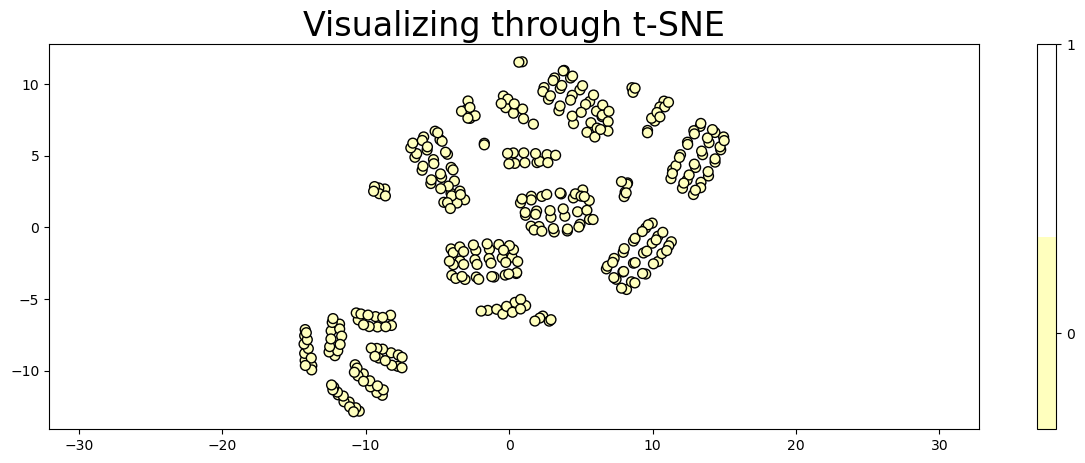

In [13]:
x_subset = data[:]
y_subset = [np.argmax(x) for x in label]

print(np.unique(y_subset))
x_subset=x_subset.reshape((x_subset.shape[0],x_subset.shape[1]))
%time
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(x_subset)
plt.scatter(tsne[:, 0], tsne[:, 1], s= 50, c=y_subset, cmap='Spectral',edgecolors='black')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(2)-0.5).set_ticks(np.arange(2))
plt.title('Visualizing through t-SNE', fontsize=24);

In [14]:
kmeans = KMeans(5)
kmeans.fit(data)
identified_clusters = kmeans.fit_predict(data)
# identified_clusters

In [15]:
count=[i for i in range(5)]
Train,Test=[],[]
TrainLabel, TestLabel=[],[]
for i in range(len(data)):
    x=identified_clusters[i]
    if x==0 and count[0] < 16:
        count[0]+=1
        Test.append(data[i])
        TestLabel.append(label[i])
    elif x==1 and count[1] < 16:
        count[1]+=1
        Test.append(data[i])
        TestLabel.append(label[i])
    elif x==2 and count[2] < 16:
        count[2]+=1
        Test.append(data[i])
        TestLabel.append(label[i])
    elif x==3 and count[3] < 17:
        count[3]+=1
        Test.append(data[i])
        TestLabel.append(label[i])
    elif x==4 and count[4] < 17:
        count[4]+=1
        Test.append(data[i])
        TestLabel.append(label[i])
    else:
        Train.append(data[i])
        TrainLabel.append(label[i])
        
Train=np.array(Train)
Test=np.array(Test)
TrainLabel=np.array(TrainLabel)
TestLabel=np.array(TestLabel)        

In [16]:
def MAPE(Y_actual,Y_Predicted):
    summ=0
    for i in range(len(Y_actual)):
        if Y_actual[i]!=0:
            summ+=np.abs((Y_actual[i] - Y_Predicted[i])/Y_actual[i])*100
        else:
            summ+=np.abs((Y_actual[i] - Y_Predicted[i]))*100
            
    mape = summ/len(Y_actual)
    return mape

def score(actual,predicted):
    mape=MAPE(actual,predicted)
    mse=mean_squared_error(actual,predicted)    
    rmse=math.sqrt(mse) 
    r2=r2_score(actual,predicted)
    return mse, rmse, mape[0],r2

In [17]:
top=5

In [228]:
reset_random_seeds(seed)

input_lyr = Input(shape=(top,))
initializer = tf.keras.initializers.HeNormal()
layer1 = Dense(100, activation='relu',kernel_initializer=initializer)(input_lyr)
layer2 = Dense(500, activation='relu',kernel_initializer=initializer)(layer1)
# layer3 = Dense(1000, activation='relu',kernel_initializer=initializer)(layer2)
# d11=Dropout(0.01)(layer3)
output_layer = Dense(1)(layer2)
model = Model(input_lyr, output_layer)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_112 (Dense)           (None, 100)               600       
                                                                 
 dense_113 (Dense)           (None, 500)               50500     
                                                                 
 dense_114 (Dense)           (None, 1)                 501       
                                                                 
Total params: 51,601
Trainable params: 51,601
Non-trainable params: 0
_________________________________________________________________


In [229]:
reset_random_seeds(seed)

callback=keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1.0e-4, patience=100, verbose=0, mode="auto", baseline=None, restore_best_weights=True)
history = model.fit(Train, TrainLabel, epochs=50000, batch_size=512,  validation_data=(Test, TestLabel), callbacks=[callback], shuffle=True)


Epoch 1/50000
1/1 [==============================] - 0s 272ms/step - loss: 579338.8125 - val_loss: 535578.1250
Epoch 2/50000
1/1 [==============================] - 0s 22ms/step - loss: 578282.0000 - val_loss: 534513.2500
Epoch 3/50000
1/1 [==============================] - 0s 27ms/step - loss: 577228.2500 - val_loss: 533451.9375
Epoch 4/50000
1/1 [==============================] - 0s 28ms/step - loss: 576175.8125 - val_loss: 532389.5625
Epoch 5/50000
1/1 [==============================] - 0s 25ms/step - loss: 575121.8125 - val_loss: 531323.8750
Epoch 6/50000
1/1 [==============================] - 0s 26ms/step - loss: 574065.2500 - val_loss: 530252.2500
Epoch 7/50000
1/1 [==============================] - 0s 26ms/step - loss: 573003.2500 - val_loss: 529172.5000
Epoch 8/50000
1/1 [==============================] - 0s 25ms/step - loss: 571933.0000 - val_loss: 528082.2500
Epoch 9/50000
1/1 [==============================] - 0s 25ms/step - loss: 570853.0000 - val_loss: 526978.5625
Epoch 10/

Epoch 75/50000
1/1 [==============================] - 0s 25ms/step - loss: 356127.5312 - val_loss: 307461.6562
Epoch 76/50000
1/1 [==============================] - 0s 25ms/step - loss: 349798.9688 - val_loss: 301154.0312
Epoch 77/50000
1/1 [==============================] - 0s 24ms/step - loss: 343398.0000 - val_loss: 294783.1250
Epoch 78/50000
1/1 [==============================] - 0s 23ms/step - loss: 336928.9062 - val_loss: 288354.9062
Epoch 79/50000
1/1 [==============================] - 0s 24ms/step - loss: 330395.3438 - val_loss: 281874.4375
Epoch 80/50000
1/1 [==============================] - 0s 24ms/step - loss: 323801.2500 - val_loss: 275347.6250
Epoch 81/50000
1/1 [==============================] - 0s 23ms/step - loss: 317152.6875 - val_loss: 268779.2500
Epoch 82/50000
1/1 [==============================] - 0s 24ms/step - loss: 310455.0000 - val_loss: 262171.9062
Epoch 83/50000
1/1 [==============================] - 0s 24ms/step - loss: 303712.9688 - val_loss: 255532.9219
E

1/1 [==============================] - 0s 27ms/step - loss: 58370.9727 - val_loss: 41256.7617
Epoch 150/50000
1/1 [==============================] - 0s 26ms/step - loss: 57946.2930 - val_loss: 41042.5508
Epoch 151/50000
1/1 [==============================] - 0s 25ms/step - loss: 57521.1445 - val_loss: 40816.0781
Epoch 152/50000
1/1 [==============================] - 0s 25ms/step - loss: 57095.0195 - val_loss: 40576.8789
Epoch 153/50000
1/1 [==============================] - 0s 25ms/step - loss: 56667.7500 - val_loss: 40325.3398
Epoch 154/50000
1/1 [==============================] - 0s 26ms/step - loss: 56239.0195 - val_loss: 40062.4609
Epoch 155/50000
1/1 [==============================] - 0s 24ms/step - loss: 55808.6602 - val_loss: 39789.1758
Epoch 156/50000
1/1 [==============================] - 0s 24ms/step - loss: 55377.4102 - val_loss: 39506.0625
Epoch 157/50000
1/1 [==============================] - 0s 23ms/step - loss: 54945.8281 - val_loss: 39214.1172
Epoch 158/50000
1/1 [=====

1/1 [==============================] - 0s 22ms/step - loss: 18408.0938 - val_loss: 14941.6455
Epoch 298/50000
1/1 [==============================] - 0s 22ms/step - loss: 18291.0352 - val_loss: 14865.5156
Epoch 299/50000
1/1 [==============================] - 0s 22ms/step - loss: 18175.7676 - val_loss: 14789.9482
Epoch 300/50000
1/1 [==============================] - 0s 22ms/step - loss: 18062.1094 - val_loss: 14715.0176
Epoch 301/50000
1/1 [==============================] - 0s 23ms/step - loss: 17950.1660 - val_loss: 14641.2275
Epoch 302/50000
1/1 [==============================] - 0s 21ms/step - loss: 17839.7188 - val_loss: 14568.1221
Epoch 303/50000
1/1 [==============================] - 0s 21ms/step - loss: 17730.5566 - val_loss: 14496.3027
Epoch 304/50000
1/1 [==============================] - 0s 21ms/step - loss: 17622.5938 - val_loss: 14425.4365
Epoch 305/50000
1/1 [==============================] - 0s 22ms/step - loss: 17515.6973 - val_loss: 14355.5508
Epoch 306/50000
1/1 [=====

1/1 [==============================] - 0s 23ms/step - loss: 12224.3203 - val_loss: 11129.7871
Epoch 446/50000
1/1 [==============================] - 0s 21ms/step - loss: 12214.9971 - val_loss: 11120.8877
Epoch 447/50000
1/1 [==============================] - 0s 21ms/step - loss: 12205.7568 - val_loss: 11111.6758
Epoch 448/50000
1/1 [==============================] - 0s 21ms/step - loss: 12196.5830 - val_loss: 11102.2227
Epoch 449/50000
1/1 [==============================] - 0s 21ms/step - loss: 12187.5312 - val_loss: 11092.9219
Epoch 450/50000
1/1 [==============================] - 0s 21ms/step - loss: 12178.5127 - val_loss: 11083.9951
Epoch 451/50000
1/1 [==============================] - 0s 20ms/step - loss: 12169.4717 - val_loss: 11075.4111
Epoch 452/50000
1/1 [==============================] - 0s 21ms/step - loss: 12160.4268 - val_loss: 11067.1738
Epoch 453/50000
1/1 [==============================] - 0s 21ms/step - loss: 12151.3457 - val_loss: 11058.9951
Epoch 454/50000
1/1 [=====

Epoch 594/50000
1/1 [==============================] - 0s 22ms/step - loss: 10855.2383 - val_loss: 9661.4912
Epoch 595/50000
1/1 [==============================] - 0s 24ms/step - loss: 10844.9424 - val_loss: 9649.3594
Epoch 596/50000
1/1 [==============================] - 0s 22ms/step - loss: 10834.6201 - val_loss: 9637.3564
Epoch 597/50000
1/1 [==============================] - 0s 22ms/step - loss: 10824.2764 - val_loss: 9625.1377
Epoch 598/50000
1/1 [==============================] - 0s 21ms/step - loss: 10813.9170 - val_loss: 9613.0752
Epoch 599/50000
1/1 [==============================] - 0s 21ms/step - loss: 10803.5225 - val_loss: 9601.0996
Epoch 600/50000
1/1 [==============================] - 0s 22ms/step - loss: 10793.1123 - val_loss: 9588.9346
Epoch 601/50000
1/1 [==============================] - 0s 21ms/step - loss: 10782.6895 - val_loss: 9576.9668
Epoch 602/50000
1/1 [==============================] - 0s 21ms/step - loss: 10772.2539 - val_loss: 9564.8418
Epoch 603/50000
1/1

Epoch 745/50000
1/1 [==============================] - 0s 21ms/step - loss: 9075.2080 - val_loss: 7503.2153
Epoch 746/50000
1/1 [==============================] - 0s 21ms/step - loss: 9062.1631 - val_loss: 7487.1772
Epoch 747/50000
1/1 [==============================] - 0s 21ms/step - loss: 9049.0986 - val_loss: 7471.5034
Epoch 748/50000
1/1 [==============================] - 0s 21ms/step - loss: 9036.0322 - val_loss: 7456.4912
Epoch 749/50000
1/1 [==============================] - 0s 21ms/step - loss: 9022.9746 - val_loss: 7442.1685
Epoch 750/50000
1/1 [==============================] - 0s 21ms/step - loss: 9009.9004 - val_loss: 7427.1372
Epoch 751/50000
1/1 [==============================] - 0s 21ms/step - loss: 8996.8564 - val_loss: 7411.7397
Epoch 752/50000
1/1 [==============================] - 0s 21ms/step - loss: 8983.7666 - val_loss: 7396.4541
Epoch 753/50000
1/1 [==============================] - 0s 21ms/step - loss: 8970.6533 - val_loss: 7381.3657
Epoch 754/50000
1/1 [=======

Epoch 821/50000
1/1 [==============================] - 0s 21ms/step - loss: 8085.2378 - val_loss: 6418.4712
Epoch 822/50000
1/1 [==============================] - 0s 21ms/step - loss: 8072.3735 - val_loss: 6404.1382
Epoch 823/50000
1/1 [==============================] - 0s 21ms/step - loss: 8059.5210 - val_loss: 6389.7529
Epoch 824/50000
1/1 [==============================] - 0s 21ms/step - loss: 8046.7354 - val_loss: 6375.1445
Epoch 825/50000
1/1 [==============================] - 0s 21ms/step - loss: 8033.9409 - val_loss: 6360.1973
Epoch 826/50000
1/1 [==============================] - 0s 22ms/step - loss: 8021.1475 - val_loss: 6345.4409
Epoch 827/50000
1/1 [==============================] - 0s 22ms/step - loss: 8008.3516 - val_loss: 6331.2803
Epoch 828/50000
1/1 [==============================] - 0s 21ms/step - loss: 7995.5347 - val_loss: 6317.5151
Epoch 829/50000
1/1 [==============================] - 0s 21ms/step - loss: 7982.7310 - val_loss: 6303.7993
Epoch 830/50000
1/1 [=======

Epoch 897/50000
1/1 [==============================] - 0s 20ms/step - loss: 7143.6509 - val_loss: 5458.2134
Epoch 898/50000
1/1 [==============================] - 0s 21ms/step - loss: 7131.8853 - val_loss: 5447.5635
Epoch 899/50000
1/1 [==============================] - 0s 21ms/step - loss: 7120.1626 - val_loss: 5436.7192
Epoch 900/50000
1/1 [==============================] - 0s 21ms/step - loss: 7108.4404 - val_loss: 5425.5737
Epoch 901/50000
1/1 [==============================] - 0s 21ms/step - loss: 7096.7290 - val_loss: 5414.4517
Epoch 902/50000
1/1 [==============================] - 0s 21ms/step - loss: 7085.0332 - val_loss: 5403.9131
Epoch 903/50000
1/1 [==============================] - 0s 21ms/step - loss: 7073.3491 - val_loss: 5393.7910
Epoch 904/50000
1/1 [==============================] - 0s 21ms/step - loss: 7061.6860 - val_loss: 5383.0981
Epoch 905/50000
1/1 [==============================] - 0s 21ms/step - loss: 7050.0298 - val_loss: 5372.0532
Epoch 906/50000
1/1 [=======

Epoch 973/50000
1/1 [==============================] - 0s 21ms/step - loss: 6295.2485 - val_loss: 4706.5093
Epoch 974/50000
1/1 [==============================] - 0s 22ms/step - loss: 6284.6260 - val_loss: 4699.0034
Epoch 975/50000
1/1 [==============================] - 0s 21ms/step - loss: 6274.0117 - val_loss: 4691.7749
Epoch 976/50000
1/1 [==============================] - 0s 21ms/step - loss: 6263.4385 - val_loss: 4683.0210
Epoch 977/50000
1/1 [==============================] - 0s 21ms/step - loss: 6252.8486 - val_loss: 4673.0142
Epoch 978/50000
1/1 [==============================] - 0s 21ms/step - loss: 6242.3169 - val_loss: 4664.2695
Epoch 979/50000
1/1 [==============================] - 0s 21ms/step - loss: 6231.8247 - val_loss: 4655.9150
Epoch 980/50000
1/1 [==============================] - 0s 21ms/step - loss: 6221.3892 - val_loss: 4646.8696
Epoch 981/50000
1/1 [==============================] - 0s 21ms/step - loss: 6210.9614 - val_loss: 4638.3110
Epoch 982/50000
1/1 [=======

1/1 [==============================] - 0s 21ms/step - loss: 4991.3477 - val_loss: 3720.9211
Epoch 1124/50000
1/1 [==============================] - 0s 21ms/step - loss: 4984.6807 - val_loss: 3718.1953
Epoch 1125/50000
1/1 [==============================] - 0s 21ms/step - loss: 4978.0581 - val_loss: 3716.0503
Epoch 1126/50000
1/1 [==============================] - 0s 21ms/step - loss: 4971.4307 - val_loss: 3713.0496
Epoch 1127/50000
1/1 [==============================] - 0s 21ms/step - loss: 4964.8472 - val_loss: 3709.4722
Epoch 1128/50000
1/1 [==============================] - 0s 20ms/step - loss: 4958.3013 - val_loss: 3706.6790
Epoch 1129/50000
1/1 [==============================] - 0s 21ms/step - loss: 4951.7163 - val_loss: 3703.7053
Epoch 1130/50000
1/1 [==============================] - 0s 21ms/step - loss: 4945.1504 - val_loss: 3699.6624
Epoch 1131/50000
1/1 [==============================] - 0s 22ms/step - loss: 4938.6704 - val_loss: 3695.8013
Epoch 1132/50000
1/1 [==============

1/1 [==============================] - 0s 21ms/step - loss: 4266.0688 - val_loss: 3296.6719
Epoch 1274/50000
1/1 [==============================] - 0s 23ms/step - loss: 4262.7046 - val_loss: 3295.6072
Epoch 1275/50000
1/1 [==============================] - 0s 19ms/step - loss: 4259.2993 - val_loss: 3296.0378
Epoch 1276/50000
1/1 [==============================] - 0s 20ms/step - loss: 4255.9165 - val_loss: 3295.4263
Epoch 1277/50000
1/1 [==============================] - 0s 21ms/step - loss: 4252.5708 - val_loss: 3293.2991
Epoch 1278/50000
1/1 [==============================] - 0s 21ms/step - loss: 4249.2275 - val_loss: 3290.4905
Epoch 1279/50000
1/1 [==============================] - 0s 21ms/step - loss: 4245.8848 - val_loss: 3287.6077
Epoch 1280/50000
1/1 [==============================] - 0s 21ms/step - loss: 4242.5981 - val_loss: 3286.6868
Epoch 1281/50000
1/1 [==============================] - 0s 22ms/step - loss: 4239.2734 - val_loss: 3286.0386
Epoch 1282/50000
1/1 [==============

1/1 [==============================] - 0s 21ms/step - loss: 3777.8420 - val_loss: 2862.3274
Epoch 1424/50000
1/1 [==============================] - 0s 21ms/step - loss: 3774.3159 - val_loss: 2857.4648
Epoch 1425/50000
1/1 [==============================] - 0s 22ms/step - loss: 3770.8372 - val_loss: 2851.9167
Epoch 1426/50000
1/1 [==============================] - 0s 21ms/step - loss: 3767.3313 - val_loss: 2845.3901
Epoch 1427/50000
1/1 [==============================] - 0s 21ms/step - loss: 3763.6189 - val_loss: 2837.9587
Epoch 1428/50000
1/1 [==============================] - 0s 21ms/step - loss: 3759.5178 - val_loss: 2828.7866
Epoch 1429/50000
1/1 [==============================] - 0s 20ms/step - loss: 3755.3040 - val_loss: 2821.2800
Epoch 1430/50000
1/1 [==============================] - 0s 21ms/step - loss: 3751.0586 - val_loss: 2816.3816
Epoch 1431/50000
1/1 [==============================] - 0s 20ms/step - loss: 3746.7014 - val_loss: 2812.6245
Epoch 1432/50000
1/1 [==============

1/1 [==============================] - 0s 21ms/step - loss: 3256.3120 - val_loss: 2457.1138
Epoch 1574/50000
1/1 [==============================] - 0s 21ms/step - loss: 3253.2158 - val_loss: 2456.0298
Epoch 1575/50000
1/1 [==============================] - 0s 21ms/step - loss: 3250.0862 - val_loss: 2455.1477
Epoch 1576/50000
1/1 [==============================] - 0s 22ms/step - loss: 3246.9355 - val_loss: 2453.0156
Epoch 1577/50000
1/1 [==============================] - 0s 21ms/step - loss: 3243.8511 - val_loss: 2449.5793
Epoch 1578/50000
1/1 [==============================] - 0s 21ms/step - loss: 3240.7805 - val_loss: 2446.1189
Epoch 1579/50000
1/1 [==============================] - 0s 21ms/step - loss: 3237.7219 - val_loss: 2444.4822
Epoch 1580/50000
1/1 [==============================] - 0s 21ms/step - loss: 3234.6680 - val_loss: 2443.3308
Epoch 1581/50000
1/1 [==============================] - 0s 21ms/step - loss: 3231.6086 - val_loss: 2442.6267
Epoch 1582/50000
1/1 [==============

1/1 [==============================] - 0s 21ms/step - loss: 2731.5618 - val_loss: 2154.9524
Epoch 1724/50000
1/1 [==============================] - 0s 21ms/step - loss: 2727.0535 - val_loss: 2152.9563
Epoch 1725/50000
1/1 [==============================] - 0s 21ms/step - loss: 2722.6243 - val_loss: 2151.3108
Epoch 1726/50000
1/1 [==============================] - 0s 21ms/step - loss: 2718.1951 - val_loss: 2149.0305
Epoch 1727/50000
1/1 [==============================] - 0s 21ms/step - loss: 2713.7444 - val_loss: 2145.5920
Epoch 1728/50000
1/1 [==============================] - 0s 21ms/step - loss: 2709.3196 - val_loss: 2142.2029
Epoch 1729/50000
1/1 [==============================] - 0s 21ms/step - loss: 2704.9150 - val_loss: 2140.0657
Epoch 1730/50000
1/1 [==============================] - 0s 21ms/step - loss: 2700.5283 - val_loss: 2138.9675
Epoch 1731/50000
1/1 [==============================] - 0s 21ms/step - loss: 2696.1597 - val_loss: 2138.3313
Epoch 1732/50000
1/1 [==============

1/1 [==============================] - 0s 21ms/step - loss: 2200.4141 - val_loss: 1868.4684
Epoch 1874/50000
1/1 [==============================] - 0s 20ms/step - loss: 2197.6760 - val_loss: 1867.4015
Epoch 1875/50000
1/1 [==============================] - 0s 21ms/step - loss: 2194.9280 - val_loss: 1867.0767
Epoch 1876/50000
1/1 [==============================] - 0s 21ms/step - loss: 2192.2170 - val_loss: 1865.3658
Epoch 1877/50000
1/1 [==============================] - 0s 22ms/step - loss: 2189.5703 - val_loss: 1863.0176
Epoch 1878/50000
1/1 [==============================] - 0s 21ms/step - loss: 2186.8569 - val_loss: 1860.8279
Epoch 1879/50000
1/1 [==============================] - 0s 21ms/step - loss: 2184.1062 - val_loss: 1859.8633
Epoch 1880/50000
1/1 [==============================] - 0s 18ms/step - loss: 2181.4409 - val_loss: 1860.3083
Epoch 1881/50000
1/1 [==============================] - 0s 23ms/step - loss: 2178.7305 - val_loss: 1859.8125
Epoch 1882/50000
1/1 [==============

1/1 [==============================] - 0s 21ms/step - loss: 1863.4855 - val_loss: 1588.8826
Epoch 2024/50000
1/1 [==============================] - 0s 21ms/step - loss: 1861.8948 - val_loss: 1584.6136
Epoch 2025/50000
1/1 [==============================] - 0s 21ms/step - loss: 1859.5594 - val_loss: 1582.6520
Epoch 2026/50000
1/1 [==============================] - 0s 19ms/step - loss: 1857.8889 - val_loss: 1583.1149
Epoch 2027/50000
1/1 [==============================] - 0s 19ms/step - loss: 1855.5673 - val_loss: 1582.7031
Epoch 2028/50000
1/1 [==============================] - 0s 22ms/step - loss: 1853.7542 - val_loss: 1579.5337
Epoch 2029/50000
1/1 [==============================] - 0s 22ms/step - loss: 1851.6237 - val_loss: 1577.0892
Epoch 2030/50000
1/1 [==============================] - 0s 18ms/step - loss: 1849.9670 - val_loss: 1577.1598
Epoch 2031/50000
1/1 [==============================] - 0s 19ms/step - loss: 1847.7509 - val_loss: 1578.5248
Epoch 2032/50000
1/1 [==============

1/1 [==============================] - 0s 20ms/step - loss: 1590.7516 - val_loss: 1371.4768
Epoch 2174/50000
1/1 [==============================] - 0s 20ms/step - loss: 1588.8717 - val_loss: 1370.5051
Epoch 2175/50000
1/1 [==============================] - 0s 20ms/step - loss: 1587.3582 - val_loss: 1368.7057
Epoch 2176/50000
1/1 [==============================] - 0s 21ms/step - loss: 1585.5875 - val_loss: 1366.7025
Epoch 2177/50000
1/1 [==============================] - 0s 21ms/step - loss: 1583.8613 - val_loss: 1366.6188
Epoch 2178/50000
1/1 [==============================] - 0s 18ms/step - loss: 1582.3267 - val_loss: 1367.5575
Epoch 2179/50000
1/1 [==============================] - 0s 20ms/step - loss: 1580.4436 - val_loss: 1366.1777
Epoch 2180/50000
1/1 [==============================] - 0s 21ms/step - loss: 1578.8600 - val_loss: 1361.3965
Epoch 2181/50000
1/1 [==============================] - 0s 22ms/step - loss: 1577.0996 - val_loss: 1359.3298
Epoch 2182/50000
1/1 [==============

1/1 [==============================] - 0s 21ms/step - loss: 1354.5220 - val_loss: 1203.0101
Epoch 2324/50000
1/1 [==============================] - 0s 21ms/step - loss: 1353.0123 - val_loss: 1202.4760
Epoch 2325/50000
1/1 [==============================] - 0s 22ms/step - loss: 1351.5391 - val_loss: 1200.5452
Epoch 2326/50000
1/1 [==============================] - 0s 21ms/step - loss: 1350.0466 - val_loss: 1200.0184
Epoch 2327/50000
1/1 [==============================] - 0s 18ms/step - loss: 1348.5139 - val_loss: 1200.0845
Epoch 2328/50000
1/1 [==============================] - 0s 22ms/step - loss: 1347.2864 - val_loss: 1196.3190
Epoch 2329/50000
1/1 [==============================] - 0s 22ms/step - loss: 1345.9016 - val_loss: 1195.3470
Epoch 2330/50000
1/1 [==============================] - 0s 19ms/step - loss: 1344.5206 - val_loss: 1196.0278
Epoch 2331/50000
1/1 [==============================] - 0s 19ms/step - loss: 1342.7090 - val_loss: 1196.2982
Epoch 2332/50000
1/1 [==============

1/1 [==============================] - 0s 20ms/step - loss: 1144.7155 - val_loss: 1073.5961
Epoch 2474/50000
1/1 [==============================] - 0s 20ms/step - loss: 1143.4425 - val_loss: 1073.4280
Epoch 2475/50000
1/1 [==============================] - 0s 21ms/step - loss: 1142.1760 - val_loss: 1071.8885
Epoch 2476/50000
1/1 [==============================] - 0s 21ms/step - loss: 1140.9236 - val_loss: 1069.6467
Epoch 2477/50000
1/1 [==============================] - 0s 21ms/step - loss: 1139.6805 - val_loss: 1068.6506
Epoch 2478/50000
1/1 [==============================] - 0s 20ms/step - loss: 1138.4176 - val_loss: 1069.0507
Epoch 2479/50000
1/1 [==============================] - 0s 18ms/step - loss: 1137.1611 - val_loss: 1069.2843
Epoch 2480/50000
1/1 [==============================] - 0s 18ms/step - loss: 1135.9484 - val_loss: 1069.4165
Epoch 2481/50000
1/1 [==============================] - 0s 24ms/step - loss: 1134.7316 - val_loss: 1065.7407
Epoch 2482/50000
1/1 [==============

1/1 [==============================] - 0s 22ms/step - loss: 969.4803 - val_loss: 961.6960
Epoch 2625/50000
1/1 [==============================] - 0s 23ms/step - loss: 968.4082 - val_loss: 959.8302
Epoch 2626/50000
1/1 [==============================] - 0s 23ms/step - loss: 967.3121 - val_loss: 957.9290
Epoch 2627/50000
1/1 [==============================] - 0s 23ms/step - loss: 966.2359 - val_loss: 957.6674
Epoch 2628/50000
1/1 [==============================] - 0s 20ms/step - loss: 965.1384 - val_loss: 958.0468
Epoch 2629/50000
1/1 [==============================] - 0s 23ms/step - loss: 964.0494 - val_loss: 957.2418
Epoch 2630/50000
1/1 [==============================] - 0s 24ms/step - loss: 962.9616 - val_loss: 956.6315
Epoch 2631/50000
1/1 [==============================] - 0s 23ms/step - loss: 961.8652 - val_loss: 955.8893
Epoch 2632/50000
1/1 [==============================] - 0s 23ms/step - loss: 960.7525 - val_loss: 954.7089
Epoch 2633/50000
1/1 [==============================] 

1/1 [==============================] - 0s 23ms/step - loss: 815.8527 - val_loss: 871.8812
Epoch 2777/50000
1/1 [==============================] - 0s 24ms/step - loss: 814.9702 - val_loss: 870.8900
Epoch 2778/50000
1/1 [==============================] - 0s 24ms/step - loss: 814.0513 - val_loss: 869.2896
Epoch 2779/50000
1/1 [==============================] - 0s 22ms/step - loss: 813.1235 - val_loss: 868.9062
Epoch 2780/50000
1/1 [==============================] - 0s 22ms/step - loss: 812.2294 - val_loss: 868.6274
Epoch 2781/50000
1/1 [==============================] - 0s 20ms/step - loss: 811.3268 - val_loss: 868.8199
Epoch 2782/50000
1/1 [==============================] - 0s 24ms/step - loss: 810.4202 - val_loss: 868.2207
Epoch 2783/50000
1/1 [==============================] - 0s 23ms/step - loss: 809.5291 - val_loss: 866.9943
Epoch 2784/50000
1/1 [==============================] - 0s 22ms/step - loss: 808.6393 - val_loss: 866.6511
Epoch 2785/50000
1/1 [==============================] 

1/1 [==============================] - 0s 24ms/step - loss: 696.1685 - val_loss: 789.5873
Epoch 2929/50000
1/1 [==============================] - 0s 21ms/step - loss: 695.5472 - val_loss: 790.2659
Epoch 2930/50000
1/1 [==============================] - 0s 20ms/step - loss: 694.8635 - val_loss: 791.8762
Epoch 2931/50000
1/1 [==============================] - 0s 21ms/step - loss: 694.1536 - val_loss: 792.3605
Epoch 2932/50000
1/1 [==============================] - 0s 21ms/step - loss: 693.5081 - val_loss: 789.8090
Epoch 2933/50000
1/1 [==============================] - 0s 23ms/step - loss: 692.8146 - val_loss: 787.7043
Epoch 2934/50000
1/1 [==============================] - 0s 21ms/step - loss: 692.1516 - val_loss: 789.0623
Epoch 2935/50000
1/1 [==============================] - 0s 21ms/step - loss: 691.4440 - val_loss: 790.7568
Epoch 2936/50000
1/1 [==============================] - 0s 20ms/step - loss: 690.8041 - val_loss: 789.3394
Epoch 2937/50000
1/1 [==============================] 

1/1 [==============================] - 0s 22ms/step - loss: 603.9488 - val_loss: 737.0234
Epoch 3081/50000
1/1 [==============================] - 0s 22ms/step - loss: 603.3671 - val_loss: 736.2176
Epoch 3082/50000
1/1 [==============================] - 0s 19ms/step - loss: 602.7906 - val_loss: 736.9246
Epoch 3083/50000
1/1 [==============================] - 0s 20ms/step - loss: 602.2715 - val_loss: 737.1985
Epoch 3084/50000
1/1 [==============================] - 0s 20ms/step - loss: 601.7288 - val_loss: 736.4887
Epoch 3085/50000
1/1 [==============================] - 0s 22ms/step - loss: 601.1719 - val_loss: 735.0546
Epoch 3086/50000
1/1 [==============================] - 0s 20ms/step - loss: 600.6953 - val_loss: 735.6791
Epoch 3087/50000
1/1 [==============================] - 0s 21ms/step - loss: 600.1920 - val_loss: 737.5809
Epoch 3088/50000
1/1 [==============================] - 0s 20ms/step - loss: 599.6744 - val_loss: 737.2737
Epoch 3089/50000
1/1 [==============================] 

1/1 [==============================] - 0s 19ms/step - loss: 527.9547 - val_loss: 704.0656
Epoch 3233/50000
1/1 [==============================] - 0s 18ms/step - loss: 527.4813 - val_loss: 704.0116
Epoch 3234/50000
1/1 [==============================] - 0s 22ms/step - loss: 527.0027 - val_loss: 703.2911
Epoch 3235/50000
1/1 [==============================] - 0s 22ms/step - loss: 526.5279 - val_loss: 702.4067
Epoch 3236/50000
1/1 [==============================] - 0s 19ms/step - loss: 526.0717 - val_loss: 702.8936
Epoch 3237/50000
1/1 [==============================] - 0s 19ms/step - loss: 525.6030 - val_loss: 703.6616
Epoch 3238/50000
1/1 [==============================] - 0s 19ms/step - loss: 525.1236 - val_loss: 703.0459
Epoch 3239/50000
1/1 [==============================] - 0s 19ms/step - loss: 524.6624 - val_loss: 702.7020
Epoch 3240/50000
1/1 [==============================] - 0s 21ms/step - loss: 524.2043 - val_loss: 702.0469
Epoch 3241/50000
1/1 [==============================] 

1/1 [==============================] - 0s 20ms/step - loss: 466.4064 - val_loss: 673.1535
Epoch 3385/50000
1/1 [==============================] - 0s 21ms/step - loss: 466.0775 - val_loss: 672.5921
Epoch 3386/50000
1/1 [==============================] - 0s 18ms/step - loss: 465.7129 - val_loss: 673.4004
Epoch 3387/50000
1/1 [==============================] - 0s 18ms/step - loss: 465.3578 - val_loss: 674.2628
Epoch 3388/50000
1/1 [==============================] - 0s 18ms/step - loss: 465.0124 - val_loss: 673.4293
Epoch 3389/50000
1/1 [==============================] - 0s 24ms/step - loss: 464.6689 - val_loss: 673.4292
Epoch 3390/50000
1/1 [==============================] - 0s 19ms/step - loss: 464.3096 - val_loss: 674.0153
Epoch 3391/50000
1/1 [==============================] - 0s 19ms/step - loss: 463.9572 - val_loss: 673.9393
Epoch 3392/50000
1/1 [==============================] - 0s 19ms/step - loss: 463.6103 - val_loss: 673.5247
Epoch 3393/50000
1/1 [==============================] 

1/1 [==============================] - 0s 20ms/step - loss: 416.6626 - val_loss: 650.7059
Epoch 3537/50000
1/1 [==============================] - 0s 19ms/step - loss: 416.3737 - val_loss: 650.0430
Epoch 3538/50000
1/1 [==============================] - 0s 19ms/step - loss: 416.0945 - val_loss: 650.2525
Epoch 3539/50000
1/1 [==============================] - 0s 19ms/step - loss: 415.8204 - val_loss: 650.6998
Epoch 3540/50000
1/1 [==============================] - 0s 19ms/step - loss: 415.5491 - val_loss: 650.2673
Epoch 3541/50000
1/1 [==============================] - 0s 20ms/step - loss: 415.2587 - val_loss: 649.5652
Epoch 3542/50000
1/1 [==============================] - 0s 18ms/step - loss: 414.9656 - val_loss: 649.3741
Epoch 3543/50000
1/1 [==============================] - 0s 20ms/step - loss: 414.6797 - val_loss: 649.5846
Epoch 3544/50000
1/1 [==============================] - 0s 19ms/step - loss: 414.4285 - val_loss: 648.7034
Epoch 3545/50000
1/1 [==============================] 

1/1 [==============================] - 0s 19ms/step - loss: 378.0534 - val_loss: 634.2209
Epoch 3689/50000
1/1 [==============================] - 0s 19ms/step - loss: 377.8319 - val_loss: 633.8983
Epoch 3690/50000
1/1 [==============================] - 0s 18ms/step - loss: 377.6214 - val_loss: 634.4350
Epoch 3691/50000
1/1 [==============================] - 0s 18ms/step - loss: 377.3701 - val_loss: 633.6655
Epoch 3692/50000
1/1 [==============================] - 0s 20ms/step - loss: 377.1613 - val_loss: 633.2443
Epoch 3693/50000
1/1 [==============================] - 0s 19ms/step - loss: 376.9565 - val_loss: 633.6431
Epoch 3694/50000
1/1 [==============================] - 0s 18ms/step - loss: 376.7399 - val_loss: 634.0958
Epoch 3695/50000
1/1 [==============================] - 0s 21ms/step - loss: 376.5136 - val_loss: 633.0942
Epoch 3696/50000
1/1 [==============================] - 0s 21ms/step - loss: 376.2984 - val_loss: 632.5322
Epoch 3697/50000
1/1 [==============================] 

1/1 [==============================] - 0s 18ms/step - loss: 348.0958 - val_loss: 617.1686
Epoch 3841/50000
1/1 [==============================] - 0s 18ms/step - loss: 347.9046 - val_loss: 617.5568
Epoch 3842/50000
1/1 [==============================] - 0s 18ms/step - loss: 347.7204 - val_loss: 616.8972
Epoch 3843/50000
1/1 [==============================] - 0s 21ms/step - loss: 347.5433 - val_loss: 616.2396
Epoch 3844/50000
1/1 [==============================] - 0s 23ms/step - loss: 347.3562 - val_loss: 615.9814
Epoch 3845/50000
1/1 [==============================] - 0s 19ms/step - loss: 347.1737 - val_loss: 616.7377
Epoch 3846/50000
1/1 [==============================] - 0s 21ms/step - loss: 347.0045 - val_loss: 615.3532
Epoch 3847/50000
1/1 [==============================] - 0s 18ms/step - loss: 346.8202 - val_loss: 615.6229
Epoch 3848/50000
1/1 [==============================] - 0s 18ms/step - loss: 346.6380 - val_loss: 616.2975
Epoch 3849/50000
1/1 [==============================] 

1/1 [==============================] - 0s 18ms/step - loss: 321.9344 - val_loss: 604.0381
Epoch 3993/50000
1/1 [==============================] - 0s 19ms/step - loss: 321.7556 - val_loss: 602.1768
Epoch 3994/50000
1/1 [==============================] - 0s 18ms/step - loss: 321.5807 - val_loss: 600.8922
Epoch 3995/50000
1/1 [==============================] - 0s 18ms/step - loss: 321.4617 - val_loss: 603.5244
Epoch 3996/50000
1/1 [==============================] - 0s 18ms/step - loss: 321.3006 - val_loss: 603.3277
Epoch 3997/50000
1/1 [==============================] - 0s 19ms/step - loss: 321.1265 - val_loss: 601.2959
Epoch 3998/50000
1/1 [==============================] - 0s 19ms/step - loss: 320.9529 - val_loss: 601.6003
Epoch 3999/50000
1/1 [==============================] - 0s 19ms/step - loss: 320.7979 - val_loss: 602.6100
Epoch 4000/50000
1/1 [==============================] - 0s 19ms/step - loss: 320.6519 - val_loss: 601.1945
Epoch 4001/50000
1/1 [==============================] 

1/1 [==============================] - 0s 18ms/step - loss: 298.2293 - val_loss: 591.2397
Epoch 4145/50000
1/1 [==============================] - 0s 21ms/step - loss: 298.0612 - val_loss: 589.3807
Epoch 4146/50000
1/1 [==============================] - 0s 18ms/step - loss: 297.8989 - val_loss: 590.0374
Epoch 4147/50000
1/1 [==============================] - 0s 18ms/step - loss: 297.7362 - val_loss: 591.7034
Epoch 4148/50000
1/1 [==============================] - 0s 18ms/step - loss: 297.6151 - val_loss: 589.4866
Epoch 4149/50000
1/1 [==============================] - 0s 18ms/step - loss: 297.4728 - val_loss: 589.7509
Epoch 4150/50000
1/1 [==============================] - 0s 19ms/step - loss: 297.2931 - val_loss: 590.1770
Epoch 4151/50000
1/1 [==============================] - 0s 21ms/step - loss: 297.1482 - val_loss: 586.8718
Epoch 4152/50000
1/1 [==============================] - 0s 19ms/step - loss: 297.0194 - val_loss: 588.9209
Epoch 4153/50000
1/1 [==============================] 

1/1 [==============================] - 0s 19ms/step - loss: 275.1967 - val_loss: 580.6362
Epoch 4297/50000
1/1 [==============================] - 0s 18ms/step - loss: 275.0302 - val_loss: 580.8512
Epoch 4298/50000
1/1 [==============================] - 0s 20ms/step - loss: 274.8668 - val_loss: 579.2285
Epoch 4299/50000
1/1 [==============================] - 0s 18ms/step - loss: 274.7124 - val_loss: 580.2793
Epoch 4300/50000
1/1 [==============================] - 0s 18ms/step - loss: 274.5605 - val_loss: 579.4708
Epoch 4301/50000
1/1 [==============================] - 0s 18ms/step - loss: 274.4020 - val_loss: 579.3862
Epoch 4302/50000
1/1 [==============================] - 0s 18ms/step - loss: 274.2318 - val_loss: 580.0322
Epoch 4303/50000
1/1 [==============================] - 0s 18ms/step - loss: 274.0827 - val_loss: 580.4359
Epoch 4304/50000
1/1 [==============================] - 0s 18ms/step - loss: 273.9355 - val_loss: 579.7652
Epoch 4305/50000
1/1 [==============================] 

9/9 [==============================] - 0s 2ms/step


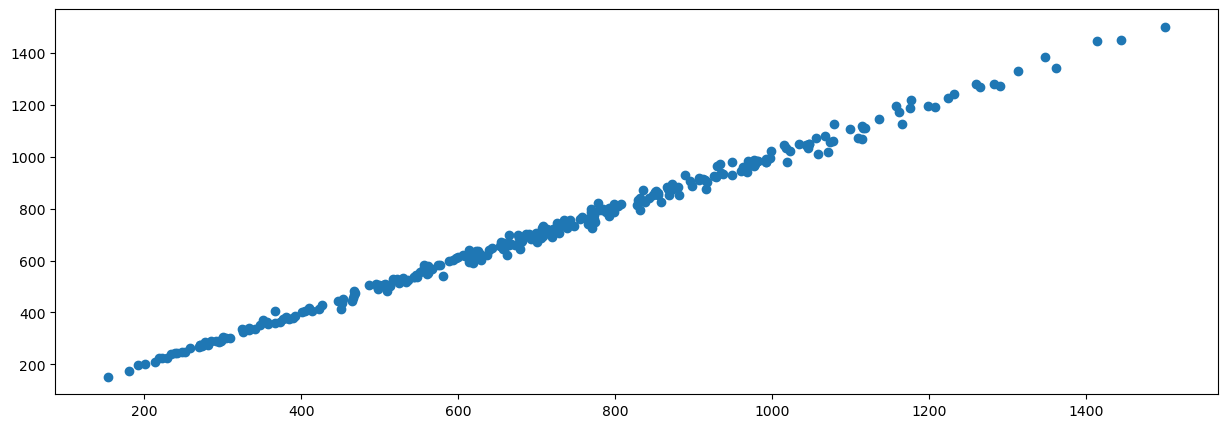

In [230]:
predict=model.predict(Train)
plt.scatter(predict,TrainLabel)

3/3 [==============================] - 0s 7ms/step


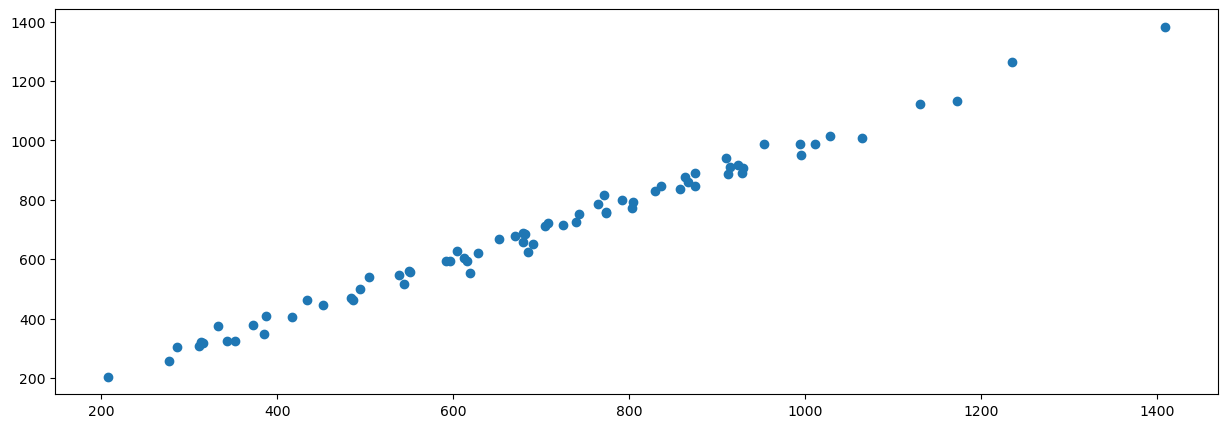

In [231]:
predictt=model.predict(Test)
plt.scatter(predictt,TestLabel)

In [232]:
score(TrainLabel,predict)

(268.3336233118801, 16.380892018198523, 1.7616649, 0.9965900862725162)

In [233]:
score(TestLabel,predictt)

(574.4955141926088, 23.968636051986955, 3.0885785, 0.9907003402665735)

In [227]:
Train.shape

(288, 5)

In [19]:
L1, L2 = [], []

Lyr = [800, 2000]
batch = [2, 4, 8, 16]
act = ['relu', 'tanh']
minum = 100

for x in Lyr:
    for y in Lyr:
        if y<=x:
            continue
        for a in act:
            for b in batch:
                
                reset_random_seeds(seed)

                input_lyr = Input(shape=(top,))
                initializer = tf.keras.initializers.HeNormal()
                layer1 = Dense(x, activation=a,kernel_initializer=initializer)(input_lyr)
                layer2 = Dense(y, activation=a,kernel_initializer=initializer)(layer1)
                # layer3 = Dense(5000, activation='relu',kernel_initializer=initializer)(layer2)
                # d11=Dropout(0.01)(layer3)
                output_layer = Dense(1)(layer2)
                model = Model(input_lyr, output_layer)

                model.compile(optimizer='adam', loss='mse')
                # model.summary()

                reset_random_seeds(seed)

                callback=keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1.0e-4, patience=100, verbose=0, mode="auto", baseline=None, restore_best_weights=True)
                history = model.fit(Train, TrainLabel, epochs=50000, batch_size=b,  validation_data=(Test, TestLabel), callbacks=[callback], shuffle=True, verbose=0)

                predict=model.predict(Train, verbose=0)

                predictt=model.predict(Test, verbose=0)

                A1,A2, A3, A4 = score(TrainLabel,predict)
                B1,B2, B3, B4 = score(TestLabel,predictt)

                L1.append([x,y,a,b,A2,B2])
                print('Current: ', end='')
                print(L1[-1])
                if L1[-1][-2]<minum:
                    minum=L1[-1][-2]
                    L2=L1[-1]
                print('Minimum: ', end='')
                print(L2)
                
                

Current: [800, 2000, 'relu', 2, 16.76021159519787, 25.112255545555985]
Minimum: [800, 2000, 'relu', 2, 16.76021159519787, 25.112255545555985]
Current: [800, 2000, 'relu', 4, 9.636777799000354, 23.055159654642765]
Minimum: [800, 2000, 'relu', 4, 9.636777799000354, 23.055159654642765]
Current: [800, 2000, 'relu', 8, 6.699970141959556, 24.646665241194984]
Minimum: [800, 2000, 'relu', 8, 6.699970141959556, 24.646665241194984]
Current: [800, 2000, 'relu', 16, 5.577635422487319, 23.44095205980812]
Minimum: [800, 2000, 'relu', 16, 5.577635422487319, 23.44095205980812]
Current: [800, 2000, 'tanh', 2, 6.999618031763467, 27.02663648661215]
Minimum: [800, 2000, 'relu', 16, 5.577635422487319, 23.44095205980812]
Current: [800, 2000, 'tanh', 4, 7.700048652468217, 28.31020365222935]
Minimum: [800, 2000, 'relu', 16, 5.577635422487319, 23.44095205980812]
Current: [800, 2000, 'tanh', 8, 10.051597743150358, 33.08626451177706]
Minimum: [800, 2000, 'relu', 16, 5.577635422487319, 23.44095205980812]
Current: